/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-23 14:22:11,674 - INFO - Starting 4x4 grid analysis for model: checkpoint-final
2025-07-23 14:22:11,675 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid an

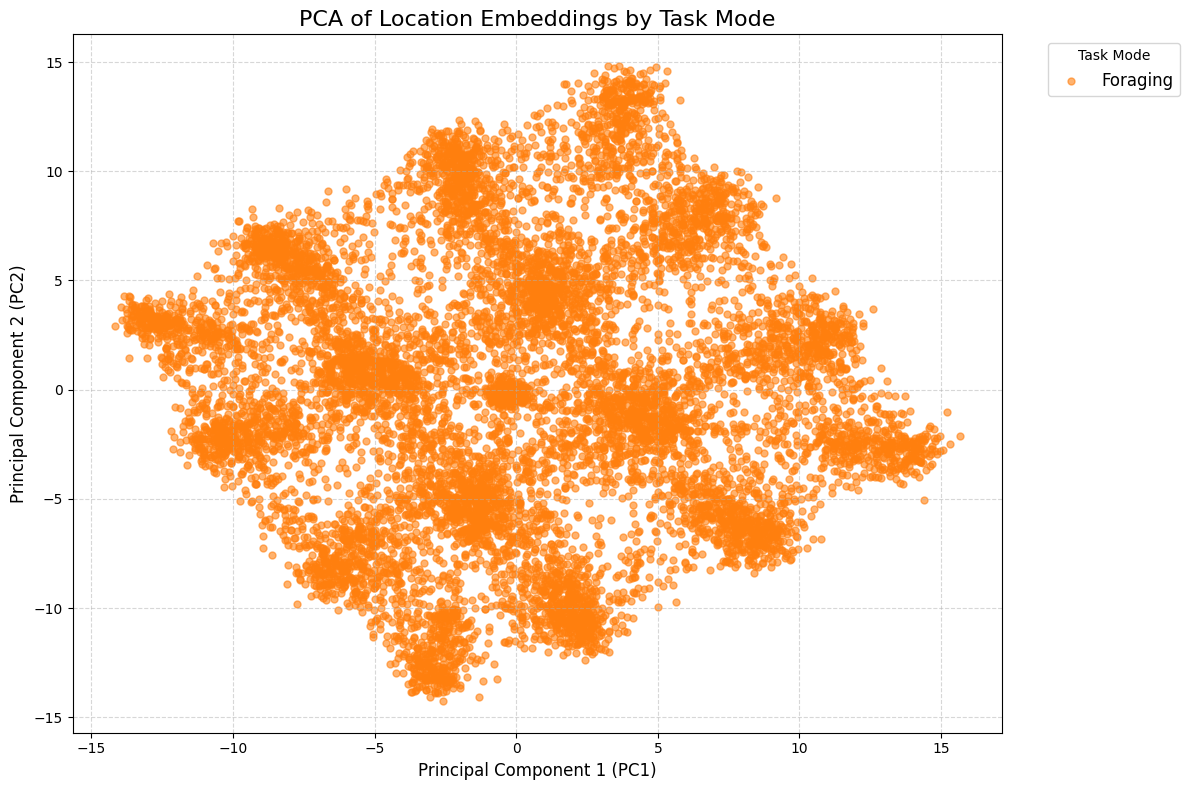

2025-07-23 14:26:06,164 - INFO - Plotting PCA for checkpoint-final, colored by 'positional_role'.
2025-07-23 14:26:07,581 - INFO - Saved plot as checkpoint-final_pca_colored_by_positional_role.png


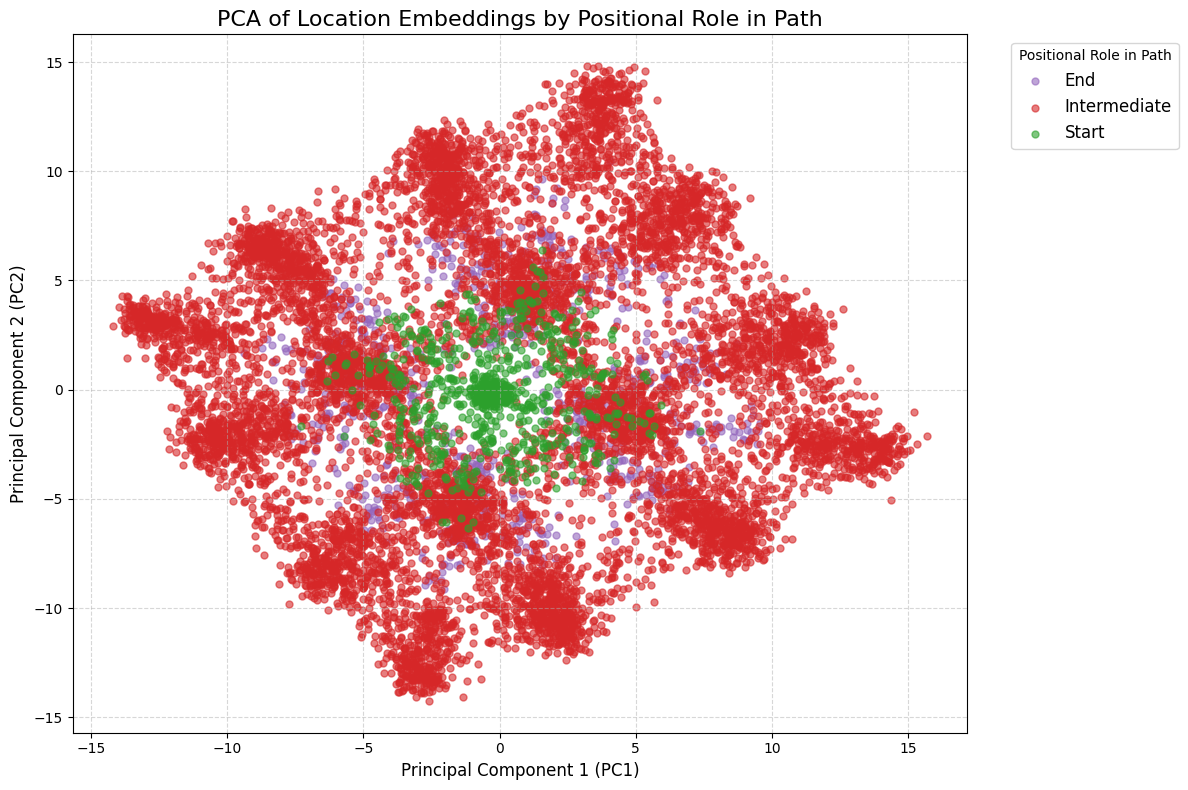

2025-07-23 14:26:07,824 - INFO - Plotting PCA for checkpoint-final, colored by 'topological_role'.
2025-07-23 14:26:10,980 - INFO - Saved plot as checkpoint-final_pca_colored_by_topological_role.png


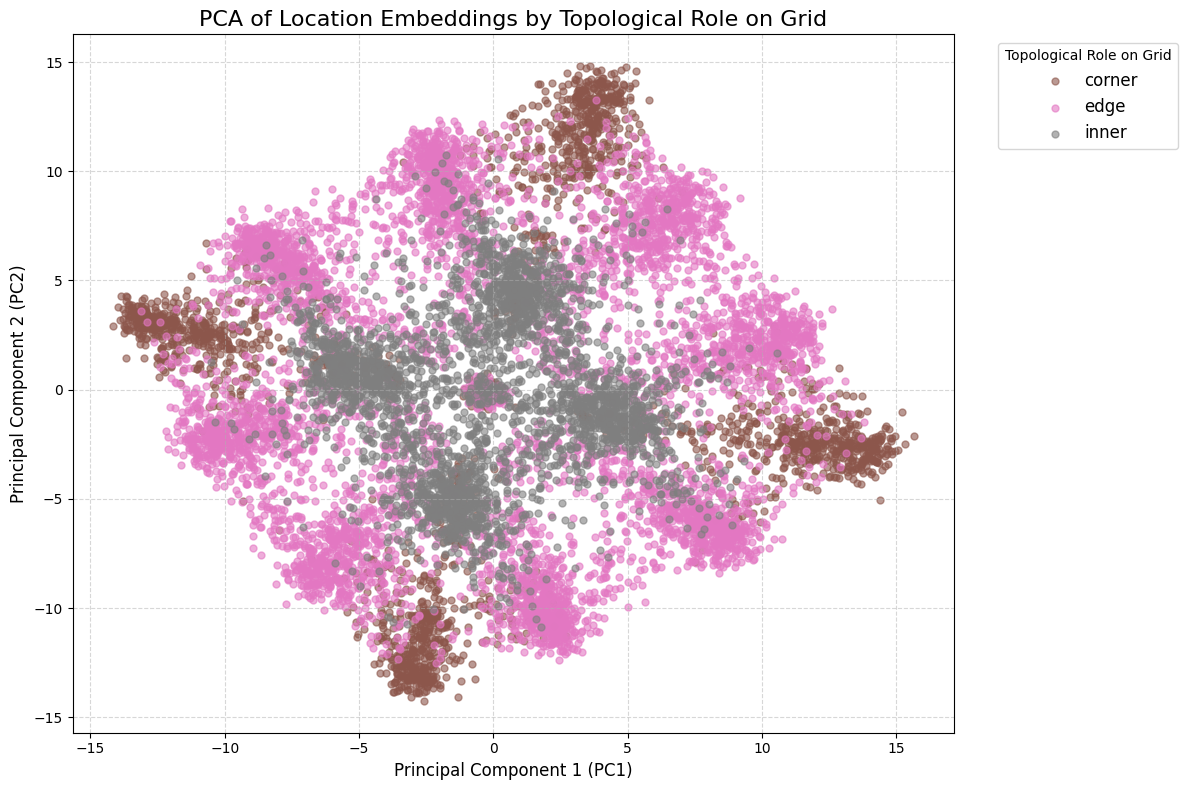

2025-07-23 14:26:11,211 - INFO - 4x4 analysis completed.


In [1]:
# %% [markdown]
# # Experiment: Analyzing Task and Spatial Representations in a Trained Model
# 
# This notebook analyzes a GPT-2 model fine-tuned on spatial navigation tasks in 4x4 grid environments. The goal is to understand what kind of representations the model learns about the environment and the tasks it performs.
# 
# ## Methodology
# 
# 1.  **Load a Trained Model**: We load one of the specialized models (`shortest_model` or `foraging_model`).
# 2.  **Generate Realistic Prompts**: We create new 4x4 grid environments and generate prompts that precisely match the format the model was trained on. This includes both `Shortest` and `Foraging` task modes.
# 3.  **Extract Hidden States**: For each location (noun) mentioned in a prompt, we extract its corresponding hidden state vector from a middle layer of the model.
# 4.  **Categorize Embeddings**: We tag each extracted embedding with metadata describing its context:
#     *   **Task Mode**: Was the prompt for a `Shortest` or `Foraging` path?
#     *   **Positional Role**: Was the location the `Start`, `Intermediate`, or `End` point of the path?
#     *   **Topological Role**: What is the location's fixed position on the 4x4 grid (`corner`, `edge`, or `inner`)?
# 5.  **Visualize with PCA**: We use Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings and create scatter plots. By coloring the points according to the categories above, we can visualize how the model organizes its internal representations.

# %%
# !pip install --upgrade huggingface_hub wonderwords umap-learn matplotlib seaborn networkx

# %%
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os
from wonderwords import RandomWord

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
#from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Set up logging to only show INFO level messages and higher
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define the paths to your trained models.
model_paths = {
    "gpt2-base": "gpt2",
    "checkpoint-final": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/all_models/generalist_v1",
}


# %%
# =============================================================================
# CELL 2: CORE GPT AND HELPER UTILITIES
# =============================================================================

class GPTWrapper:
    """Handles loading the model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='gpt2'):
        logging.info(f"Loading model: {model_name}")
        path = model_paths.get(model_name, model_name)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        logging.info("Model and tokenizer loaded successfully.")

    def get_hidden_states_with_offsets(self, prompt, layer_idx):
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             truncation=True,
                             return_offsets_mapping=True)
        with torch.no_grad():
            out = self.model(**enc)
        hidden_states = out.hidden_states[layer_idx].squeeze(0).detach().numpy()
        offsets = enc["offset_mapping"][0].tolist()
        return hidden_states, offsets

def substring_positions(haystack, needle):
    """Finds all start and end positions of a substring in a string."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1: break
        # Ensure it's a whole word to avoid matching substrings
        is_word_start = (idx == 0) or (not haystack[idx-1].isalnum())
        is_word_end = (idx + len(needle) == len(haystack)) or (not haystack[idx + len(needle)].isalnum())
        if is_word_start and is_word_end:
            result.append([idx, idx + len(needle)])
        start = idx + 1
    return result

def gather_embeddings_for_span(offsets, hidden_states, span):
    """Averages the embeddings of tokens that overlap with a given character span."""
    (start_needed, end_needed) = span
    overlap_vecs = [hidden_states[i] for i, (start_off, end_off) in enumerate(offsets) 
                  if not (end_off <= start_needed or start_off >= end_needed)]
    return np.mean(overlap_vecs, axis=0) if overlap_vecs else None


# %%
# =============================================================================
# CELL 3: UTILITIES FOR 4x4 GRID ANALYSIS
# =============================================================================

w = RandomWord()

def get_grid_graph_4x4():
    """Creates a 4x4 directed grid graph with unique noun-based names."""
    nodes = set()
    while len(nodes) < 16:
        nodes.add(w.word(include_parts_of_speech=["noun"]).replace(" ", "_"))
    nodes = list(nodes)
    
    G = nx.DiGraph()
    grid_indices = np.arange(16).reshape(4, 4)
    for r in range(4):
        for c in range(4):
            current_node = nodes[grid_indices[r, c]]
            G.add_node(current_node)
            if c < 3: # East
                neighbor = nodes[grid_indices[r, c + 1]]
                G.add_edge(current_node, neighbor, direction='R'); G.add_edge(neighbor, current_node, direction='L')
            if r < 3: # South
                neighbor = nodes[grid_indices[r + 1, c]]
                G.add_edge(current_node, neighbor, direction='D'); G.add_edge(neighbor, current_node, direction='U')
    return G, nodes

def build_positions_4x4(node_names):
    """Maps 4x4 node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 4, i % 4) for i in range(16)}

def get_topological_role_4x4(position):
    """Determines the topological role (corner, edge, inner) for a 4x4 grid."""
    r, c = position
    if r in {0, 3} and c in {0, 3}: return 'corner'
    if r in {0, 3} or c in {0, 3}: return 'edge'
    return 'inner'

def get_movement_options_string(G, start_node):
    """Generates the '[U D L R]' options string based on valid moves."""
    options = {"U": "NA", "D": "NA", "L": "NA", "R": "NA"}
    for _, neighbor in G.edges(start_node):
        direction = G.edges[(start_node, neighbor)]['direction']
        options[direction] = direction
    return f"[{' '.join(options.values())}]"

def generate_4x4_task_prompt(G, node_names):
    """Generates a realistic prompt for a 4x4 grid, matching the training data format."""
    #mode = random.choice(["Shortest", "Foraging"])
    #mode = random.choice(["Shortest"])
    mode = random.choice(["Foraging"])
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        except nx.NetworkXNoPath:
            return None, None, None
    else:  # Foraging mode
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(random.randint(20, 20)):
            neighbors = list(G.successors(current_node))
            if not neighbors: break
            if len(path_nodes) > 1 and len(neighbors) > 1 and path_nodes[-2] in neighbors:
                neighbors.remove(path_nodes[-2])
            if not neighbors: break
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        end_node = path_nodes[-1]
        if start_node == end_node: return None, None, None

    options_str = get_movement_options_string(G, start_node)
    path_str_parts = [start_node, options_str] + [
    #path_str_parts = [start_node] + [
        item for i in range(len(path_nodes) - 1) 
        for item in (G.edges[(path_nodes[i], path_nodes[i+1])]['direction'], path_nodes[i+1])
    ]
    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"
    return prompt, path_nodes, mode


# %%
# =============================================================================
# CELL 4: PLOTTING FUNCTION
# =============================================================================

def plot_by_property(all_points, model_name, reducer="pca", color_by='task_mode'):
    """Performs PCA/UMAP and plots the results, colored by a specified property."""
    if not all_points:
        logging.error("No data to plot.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by '{color_by}'.")
    X = np.array([pt['vector'] for pt in all_points])
    
    dim_red = PCA(n_components=2, random_state=42) if reducer.lower() == "pca" else UMAP(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(12, 8))
    
    grouping_key = color_by
    groups = sorted(list(set(pt[grouping_key] for pt in all_points)))
    
    color_maps = {
        'task_mode': ({'Shortest': '#1f77b4', 'Foraging': '#ff7f0e'}, "Task Mode"),
        'positional_role': ({'Start': '#2ca02c', 'Intermediate': '#d62728', 'End': '#9467bd'}, "Positional Role in Path"),
        'topological_role': ({'corner': '#8c564b', 'edge': '#e377c2', 'inner': '#7f7f7f'}, "Topological Role on Grid")
    }
    color_map, legend_title = color_maps.get(color_by)
    if color_by == 'topological_role': groups = ['corner', 'edge', 'inner']

    for group in groups:
        group_indices = [i for i, p in enumerate(all_points) if p.get(grouping_key) == group]
        if not group_indices: continue
        plt.scatter(X_2d[group_indices, 0], X_2d[group_indices, 1], 
                    color=color_map.get(group), alpha=0.6, s=25, label=str(group))

    plt.title(f'PCA of Location Embeddings by {legend_title}', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title=legend_title, fontsize=12, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_{color_by}.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved plot as {filename}")
    plt.show()

# %%
# =============================================================================
# CELL 5: MAIN ANALYSIS FUNCTION
# =============================================================================

def run_4x4_analysis(
    model_name="foraging_model",
    layer_idx=6,
    num_prompts=300,
    reducer="pca"
):
    """Main function to run the entire analysis pipeline for 4x4 grids."""
    logging.info(f"Starting 4x4 grid analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0:
            logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_4x4()
        node_positions = build_positions_4x4(node_names)
        
        prompt_data = generate_4x4_task_prompt(G, node_names)
        # --- FIX IS HERE ---
        # Explicitly check if the prompt data is valid before unpacking
        if not prompt_data or prompt_data[0] is None:
            continue
        prompt, path_nodes, mode = prompt_data
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        for node in unique_nodes_in_path:
            pos_list = substring_positions(prompt, node)
            vecs = [gather_embeddings_for_span(offsets, hidden_states, span) for span in pos_list]
            vecs = [v for v in vecs if v is not None]
            if not vecs: continue

            final_vec = np.mean(vecs, axis=0)
            positional_role = 'Start' if node == path_nodes[0] else 'End' if node == path_nodes[-1] else 'Intermediate'
            grid_pos = node_positions[node]
            
            all_points.append({
                'vector': final_vec,
                'task_mode': mode,
                'positional_role': positional_role,
                'topological_role': get_topological_role_4x4(grid_pos),
            })

    if not all_points:
        logging.error("Failed to gather any data points. Aborting plots.")
        return
        
    plot_by_property(all_points, model_name, reducer=reducer, color_by='task_mode')
    plot_by_property(all_points, model_name, reducer=reducer, color_by='positional_role')
    plot_by_property(all_points, model_name, reducer=reducer, color_by='topological_role')
    
    logging.info("4x4 analysis completed.")


# %%
# =============================================================================
# CELL 6: EXECUTE THE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    # Select the model to test. 'foraging_model' is a good choice as it has seen
    # a wider variety of path structures.
    model_to_analyze = "checkpoint-final"
    
    run_4x4_analysis(
        model_name=model_to_analyze,
        layer_idx=6,          # Middle layer of GPT-2 Small (12 layers total)
        num_prompts=1000,
        reducer="pca"
    )

2025-07-23 14:26:11,276 - INFO - Starting coordinate-based analysis for model: checkpoint-final
2025-07-23 14:26:11,278 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-23 14:26:11,520 - INFO - Model and tokenizer loaded successfully.
2025-07-23 14:26:15,532 - INFO - Processing prompt #50...
2025-07-23 14:26:19,488 - INFO - Processing prompt #100...
2025-07-23 14:26:23,203 - INFO - Processing prompt #150...
2025-07-23 14:26:

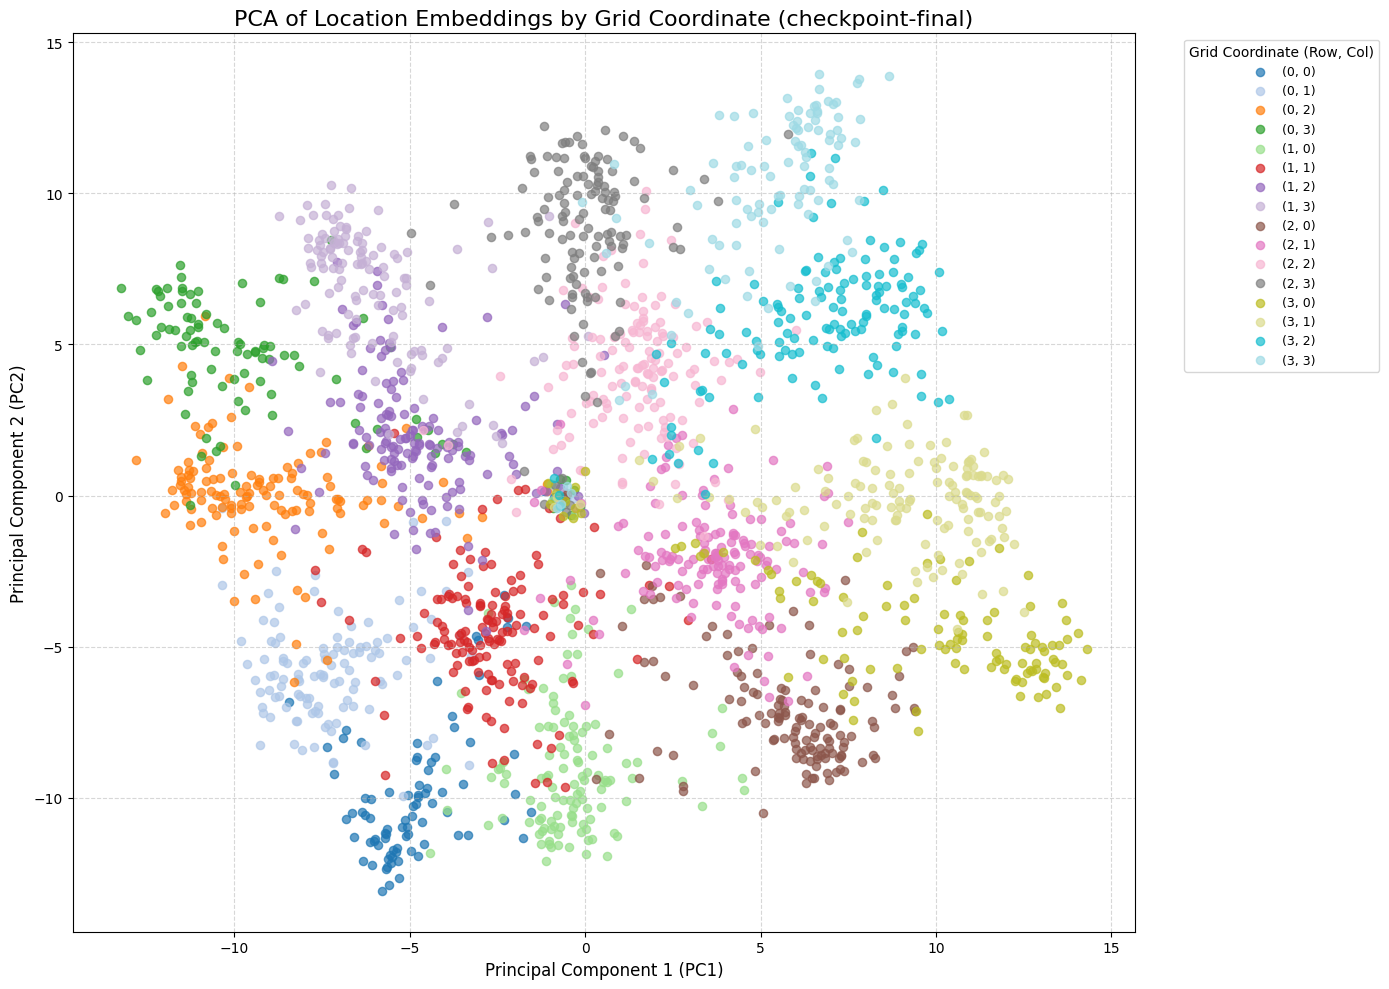

2025-07-23 14:26:27,037 - INFO - Coordinate-based analysis completed.


In [2]:
# %% [markdown]
# ### Analysis 2: Visualizing the Model's Internal "Mental Map"
# 
# This experiment investigates whether the model learns a coherent spatial representation of the 4x4 grid. If the model has a "mental map," we would expect locations that are close to each other on the grid (e.g., (0,0) and (0,1)) to have similar hidden state representations.
# 
# **Method:**
# 1.  We run the same data collection process as before, gathering embeddings for locations from various prompts.
# 2.  We perform PCA on these embeddings.
# 3.  Instead of coloring by task role, we color each point based on its **(row, col) coordinate** on the 4x4 grid. A unique color will be assigned to each of the 16 possible coordinates.
# 
# A successful result would show distinct, colored clusters that mirror the grid's topology. For example, the four corner coordinates might form their own groups in the PCA plot.

# %%
# =============================================================================
# CELL 7: PLOTTING FUNCTION FOR GRID COORDINATES
# =============================================================================

def plot_by_coordinate(all_points, model_name, reducer="pca"):
    """
    Performs PCA/UMAP and plots the results, coloring each point by its
    (row, col) grid coordinate to visualize the model's spatial map.
    """
    if not all_points:
        logging.error("No data to plot for coordinate analysis.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by grid coordinate.")
    X = np.array([pt['vector'] for pt in all_points])
    
    # Use PCA or UMAP for dimensionality reduction
    dim_red = PCA(n_components=2, random_state=42) if reducer.lower() == "pca" else UMAP(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(14, 10))
    
    # Create a unique color for each of the 16 coordinates
    # We use a string representation of the tuple for easy grouping
    coordinates = [str(p['grid_position']) for p in all_points]
    unique_coords = sorted(list(set(coordinates)), key=lambda c: eval(c))
    
    # Use a colormap that provides many distinct colors
    cmap = plt.get_cmap("tab20", len(unique_coords))
    color_map = {coord: cmap(i) for i, coord in enumerate(unique_coords)}
    legend_title = "Grid Coordinate (Row, Col)"

    for coord_str in unique_coords:
        # Find all points that match the current coordinate
        indices = [i for i, c in enumerate(coordinates) if c == coord_str]
        if not indices: continue
        
        plt.scatter(X_2d[indices, 0], X_2d[indices, 1], 
                    color=color_map.get(coord_str), alpha=0.7, s=35, label=coord_str)

    plt.title(f'PCA of Location Embeddings by Grid Coordinate ({model_name})', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # The legend can get very crowded with 16 items, so we place it outside
    plt.legend(title=legend_title, fontsize=9, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_coordinate.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved coordinate plot as {filename}")
    plt.show()


# =============================================================================
# CELL 8: ANALYSIS RUNNER FOR COORDINATE PLOT
# =============================================================================

def run_coordinate_analysis(
    model_name="foraging_model",
    layer_idx=6,
    num_prompts=400, # Use more prompts to ensure all coordinates are well-represented
    reducer="pca"
):
    """
    Main function to run the analysis pipeline specifically for visualizing
    the model's spatial map by coloring points by their grid coordinates.
    """
    logging.info(f"Starting coordinate-based analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    # We need to collect enough points to see clusters for all 16 coordinates
    prompts_processed = 0
    while len(all_points) < num_prompts * 5 and prompts_processed < num_prompts * 2: # Set a max limit
        prompts_processed += 1
        if prompts_processed % 50 == 0:
            logging.info(f"Processing prompt #{prompts_processed}...")
            
        G, node_names = get_grid_graph_4x4()
        node_positions = build_positions_4x4(node_names)
        
        prompt_data = generate_4x4_task_prompt(G, node_names)
        if not prompt_data or prompt_data[0] is None:
            continue
        prompt, path_nodes, _ = prompt_data
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        for node in unique_nodes_in_path:
            pos_list = substring_positions(prompt, node)
            vecs = [gather_embeddings_for_span(offsets, hidden_states, span) for span in pos_list]
            vecs = [v for v in vecs if v is not None]
            if not vecs: continue

            final_vec = np.mean(vecs, axis=0)
            
            # Store the vector and its corresponding grid position
            all_points.append({
                'vector': final_vec,
                'grid_position': node_positions[node],
            })

    # Call the new plotting function
    plot_by_coordinate(all_points, model_name, reducer=reducer)
    
    logging.info("Coordinate-based analysis completed.")


# %%
# =============================================================================
# CELL 9: EXECUTE THE COORDINATE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    model_to_analyze = "checkpoint-final"  # Use the final checkpoint for analysis
    
    # Run the new analysis to plot by grid coordinate
    run_coordinate_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=400,
        reducer="pca"
    )